In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from itertools import permutations
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.linear_model import LinearRegression
import difflib
from moviepy.editor import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### SVM or KNN decoding of supervised behavior labels

In [3]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
full_data = pd.read_pickle('.\\fully_labeled_traces_feats3_042224_baseline_corrected.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping

### Formatting behavior labels (aggro vs investigation)

a. Binary labels must be processed as usual.

b. Aggro cannot be investigation or vice verse, therefore labels in one must be filtered out in the other.

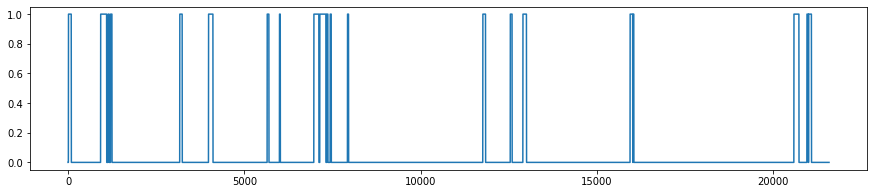

In [5]:
plt.figure(figsize=(15,3))
plt.plot(full_data['3095_d4_balbc_t3']['attack labels'])
# plt.plot(full_data['3095_d4_balbc_t3']['investigation labels'])

In [84]:
def format4analysis(full_data, animal_ID, binary_labels='attack labels', beh='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index)+1, 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array
    
    sessions2map = [x for x in sessions if animal_ID in x]
    if beh == 'aggression':
        sessions2map = [x for x in sessions2map if '_balbc_' in x or '_mCD1_' in x]
    elif beh == 'observation':
        sessions2map = [x for x in sessions2map if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions2map = [x for x in sessions2map if '_toy_' in x or '_toyCD1_' in x]

    for i, sesh in enumerate(sessions2map):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan
        try:
            traces_lib[:, -1, i] = s[binary_labels]
        except KeyError:
            traces_lib[:, -1, i] = np.nan
        
    return traces_lib, s.columns

def produce_XY(epoch):
    
    epoch_df = pd.DataFrame()
    for i in range(epoch.shape[-1]):
        epoch_df = pd.concat([epoch_df, pd.DataFrame(epoch[:, :, i])])
    concat_sessions = epoch_df.to_numpy()
    filtered_sessions = concat_sessions[np.invert(np.isnan(concat_sessions[:, -1]))]

    X = filtered_sessions[:, :-1]
    orig_X = X.copy()
    if np.isnan(X).any(axis=0).any(): # remove columns with nan
        has_nan = np.isnan(X).any(axis=0)
        X = X[:, ~has_nan]
    y_init = filtered_sessions[:, -1]
    y = y_init.astype(int).reshape(-1,1)

    return X, y
    
def get_indices(partial_list):
    present_indices = [indices[val] for val in partial_list if val in indices]
    not_present = [val for val in np.arange(len(region_ids)) if val not in present_indices]
    return present_indices, not_present
    
def add_nan_values(matrix, rois, n_features=22):
    
    if len(rois) < n_features: 
        
        # Get roi indices
        pres_idxs, miss_idxs = get_indices(rois)
        # Create a copy of the original matrix to avoid modifying it
        matrix_copy = matrix.copy()
        # Create a 1D boolean mask that indicates where to add NaN values
        nan_mask = np.zeros(matrix_copy.shape[2], dtype=bool)
        print(miss_idxs)
        nan_mask[miss_idxs] = True
        # Add NaN values to the matrix
        matrix_copy = np.insert(matrix_copy, miss_idxs, np.nan, axis=2)
                
        return matrix_copy
    
    else:
        
        return matrix

def extract_events_of_interest(labels):
    events = []
    indices = []
    start_idx = None

    for i in range(len(labels)):
        if labels[i] == 1:
            if start_idx is None:
                start_idx = i
            indices.append(i)
        elif start_idx is not None:
            if len(indices) >= 8:
                events.append(indices)
            start_idx = None
            indices = []

    if start_idx is not None and len(indices) >= 1:
        events.append(np.asarray(indices))
    return events

def confidence(var):
    meanv = np.mean(var)
    semv = stats.sem(var)
    ci = 1.96 * semv
    return ci


def error_values(var, error_type='std'):
    if error_type == 'std':
        return np.nanstd(var)
    elif error_type == 'ci':
        return confidence(var.T)
    elif error_type == 'sem':
        return scipy.stats.sem(var)

Implement label processing

In [6]:
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '87L2', '86L']
non_animals = ['87R2', '87B', '86L2', '87L']
animals = np.concatenate([agg_animals, obs_animals, non_animals])
new_data = full_data.copy()

for a, animal in enumerate(animals): 
    try:
        if a <= 11:
            context='aggression'
            all_sessions = [x for x in full_data.keys() if animal in x if 'balbc' in x or '_mCD1_' in x]
        elif a<=15:
            context='observation'
            all_sessions = [x for x in full_data.keys() if animal in x if 'obs' in x or '_OBSmCD1_' in x]
        else:
            context='nonsocial'
            all_sessions = [x for x in full_data.keys() if animal in x if 'toy' in x or '_toyCD1_' in x]
        trial_comps, rois = format4analysis(full_data, animal, beh=context, binary_labels='attack labels')
        rois = rois[:-3]

        for i in np.arange(trial_comps.shape[2]):    

            y = trial_comps[:, -1, i]
            y = y[~np.isnan(y)]

            events = extract_events_of_interest(y)
            processed_labels = np.zeros((len(y)))
            try:
                processed_labels[np.hstack(events)] = 1
            except ValueError:
                processed_labels = np.zeros((len(y)))
            new_data[all_sessions[i]]['attack labels'] = processed_labels
            new_data[all_sessions[i]].rename(columns={'attack labels':'aggression labels'}, inplace=True)
    except (UnboundLocalError, ValueError):
        print('Error in  %s for context %s...' % (animal, context))
        continue


### Prepping data for decoding

In [91]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

def format4analysis(full_data, animal_ID, binary_labels='attack labels', exp='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    epochs = [[0, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18], [18, 21], [21,24], [24, 28]]
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index)+1, 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array

    if exp == 'aggression':
        sessions2map = [x for x in sessions if '_balbc_' in x or '_mCD1_' in x]
    elif exp == 'observation':
        sessions2map = [x for x in sessions if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions2map = [x for x in sessions if '_toy_' in x or '_toyCD1_' in x]

    for i, sesh in enumerate([x for x in sessions2map if animal_ID in x]):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        not_na_cols = s.columns[s.notna().all()].tolist()
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan
        traces_lib[:, -1, i] = s[binary_labels]

    # separate into epochs

    d1 = traces_lib[:, :, epochs[0][0]:epochs[0][1]]
    d2 = traces_lib[:, :, epochs[1][0]:epochs[1][1]]
    d3 = traces_lib[:, :, epochs[2][0]:epochs[2][1]]
    d4 = traces_lib[:, :, epochs[3][0]:epochs[3][1]]
    d5 = traces_lib[:, :, epochs[4][0]:epochs[4][1]]
    d6 = traces_lib[: ,:, epochs[5][0]:epochs[5][1]]
    d7 = traces_lib[: ,:, epochs[6][0]:epochs[6][1]]
    d8 = traces_lib[: ,:, epochs[7][0]:epochs[7][1]]
    d9 = traces_lib[: ,:, epochs[8][0]:epochs[8][1]]
    trial_comps = [d1, d2, d3, d4, d5, d6, d7, d8, d9] 

    return trial_comps, traces_lib, not_na_cols

def temporal_resample(X, y, window_size):

    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)

    # Separate the minority and majority classes
    minority_data = data[data.iloc[:, -1] == 1]
    majority_data = data[data.iloc[:, -1] == 0]

    # Calculate the number of samples to generate
    num_samples = len(majority_data) - len(minority_data)

    # Generate new samples
    new_samples = minority_data.sample(n=num_samples, replace=True, random_state=42)

    # Add the new samples to the original data
    resampled_data = pd.concat([majority_data, new_samples])

    # Sort the data by the time column to maintain temporal structure
    resampled_data = resampled_data.sort_index()

    # Separate resampled X and y
    X_resampled = resampled_data.iloc[:, :-1]
    y_resampled = resampled_data.iloc[:, -1]

    return X_resampled, y_resampled

Run KNN decoder on aggression experience data

In [8]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

In [16]:
def run_KNN(new_data, animals, binary_labels):
    
    # For saving baseline scores
    grid_scores = np.zeros((9, len(animals)))
    held_out_scores = grid_scores.copy()
    
    shuffled_held_out_scores = grid_scores.copy()

    # For predicting on last BC
    late_scores = np.zeros((7, len(animals)))
    late_f1s = np.zeros((7, len(animals)))
    late_shuffled_held_out_scores = late_scores.copy()

    # For predicting on CD1
    cd1_scores = np.zeros((8, len(animals)))
    cd1_f1s = np.zeros((8, len(animals)))
    
    cd1_shuffled_held_out_scores = cd1_scores.copy()

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        if a <= 11:
            exp='aggression'
        elif a<=15:
            exp='observation'
        else:
            exp='nonsocial'

        # load animal data
        trial_comps, _, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]

        for e, epoch in enumerate(trial_comps):

            print('Beginning epoch %i for animal %s' % (e, animal))

            # Divide data into inputs and outputs
            X, y = produce_XY(epoch)

            # Perform random undersampling to balance the classes
            rus = RandomUnderSampler(random_state=42)
            X_resampled, y_resampled = rus.fit_resample(X, y)
            # X_resampled, y_resampled = temporal_resample(X.copy(), y.copy(), window_size=100)
            # y_resampled = y_resampled.values
            # X_resampled = X_resampled.values

            # Create a KNN classifier
            knn_classifier = KNeighborsClassifier()

            # Define a grid of hyperparameters to search
            param_grid = {
                'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                'weights': ['uniform', 'distance'],  # Weighting strategy
                'metric': ['euclidean', 'manhattan']  # Distance metric
            }


            # Create a GridSearchCV object with balanced accuracy as the scoring metric
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

            # Perform the grid search on your data
            grid_search.fit(X_resampled, y_resampled)
            best_model = grid_search.best_estimator_

            # Print the best parameters and best balanced accuracy score
            print("Best Parameters (XVAL):", grid_search.best_params_)
            score = grid_search.best_score_
            grid_scores[e, a] = score
            print("Best Balanced Accuracy (XVAL):", score)

            # Print scores on shuffled set
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
            X_shuf = X_resampled.copy()
            np.random.shuffle(X_shuf)
            grid_search.fit(X_shuf, y_resampled)
            score = grid_search.best_score_
            print("Best Shuffled Accuracy (XVAL):", score)
            shuffled_held_out_scores[e, a] = score

            if e in [0, 1, 2, 3, 4, 5, 6]:
                # Print scores using late held out set
                X_late, y_late = produce_XY(trial_comps[-2])
                y_pred = best_model.predict(X_late)
                score = balanced_accuracy_score(y_late, y_pred)
                late_scores[e, a] = score
                print("Best Balanced Accuracy (late):", score)
                score = f1_score(y_late, y_pred, average='weighted')
                late_f1s[e, a] = score
                print("Best F1 score (late):", score)
                
                # Print scores on shuffled set
                X_late_shuf = X_late.copy()
                np.random.shuffle(X_late_shuf)
                y_pred = best_model.predict(X_late_shuf)
                score = balanced_accuracy_score(y_late, y_pred)
                late_shuffled_held_out_scores[e, a] = score

            if e != 8:
                # Print scores using CD1 held out set
                X_cd1, y_cd1 = produce_XY(trial_comps[-1])
                y_pred = best_model.predict(X_cd1)
                score = balanced_accuracy_score(y_cd1, y_pred)
                cd1_scores[e, a] = score
                print("Best Balanced Accuracy (cd1):", score)
                score = f1_score(y_cd1, y_pred, average='weighted')
                cd1_f1s[e, a] = score
                print("Best F1 score (cd1):", score)
                
                # Print scores on shuffled set
                X_cd1_shuf = X_cd1.copy()
                np.random.shuffle(X_cd1_shuf)
                y_pred = best_model.predict(X_cd1_shuf)
                score = balanced_accuracy_score(y_cd1, y_pred)
                cd1_shuffled_held_out_scores[e, a] = score
                
    return grid_scores, shuffled_held_out_scores, late_scores, late_f1s, late_shuffled_held_out_scores, cd1_scores, cd1_f1s, cd1_shuffled_held_out_scores

grid_scores, shuffled_held_out_scores, late_scores, late_f1s, late_shuffled_held_out_scores, cd1_scores, cd1_f1s, cd1_shuffled_held_out_scores = run_KNN(full_data, animals, 'aggression labels') # aggro experience
# agg_grid_scores, agg_shuffled_held_out_scores, agg_late_scores, agg_late_f1s, agg_cd1_scores, agg_cd1_f1s = run_KNN(new_data, agg_animals, 'aggression labels', 'aggression') # aggro experience


Processing data for 3095
Beginning epoch 0 for animal 3095
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.7304321699396645
Best Shuffled Accuracy (XVAL): 0.4921438898954959
Best Balanced Accuracy (late): 0.5148836643193091
Best F1 score (late): 0.8248445263448875
Best Balanced Accuracy (cd1): 0.4979612186650013
Best F1 score (cd1): 0.8766984447049904
Beginning epoch 1 for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.656883191663419
Best Shuffled Accuracy (XVAL): 0.5099467377298406
Best Balanced Accuracy (late): 0.5816278365453869
Best F1 score (late): 0.8857300727662828
Best Balanced Accuracy (cd1): 0.6559272200516465
Best F1 score (cd1): 0.9226558698147971
Beginning epoch 2 for animal 3095
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.74324324324324

In [29]:
agg_grid_scores, agg_shuffled_held_out_scores, agg_late_scores, agg_late_f1s, agg_late_shuffled_held_out_scores, agg_cd1_scores, agg_cd1_f1s, agg_cd1_shuffled_held_out_scores = grid_scores[:, :12], shuffled_held_out_scores[:, :12], late_scores[:, :12], late_f1s[:, :12], late_shuffled_held_out_scores[:, :12], cd1_scores[:, :12], cd1_f1s[:, :12], cd1_shuffled_held_out_scores[:, :12]
obs_grid_scores, obs_shuffled_held_out_scores, obs_late_scores, obs_late_f1s, obs_late_shuffled_held_out_scores, obs_cd1_scores, obs_cd1_f1s, obs_cd1_shuffled_held_out_scores = grid_scores[:, 12:16], shuffled_held_out_scores[:, 12:16], late_scores[:, 12:16], late_f1s[:, 12:16], late_shuffled_held_out_scores[:, 12:16], cd1_scores[:, 12:16], cd1_f1s[:, 12:16], cd1_shuffled_held_out_scores[:, 12:16]
non_grid_scores, non_shuffled_held_out_scores, non_late_scores, non_late_f1s, non_late_shuffled_held_out_scores, non_cd1_scores, non_cd1_f1s, non_cd1_shuffled_held_out_scores = grid_scores[:, 16:], shuffled_held_out_scores[:, 16:], late_scores[:, 16:], late_f1s[:, 16:], late_shuffled_held_out_scores[:, 16:], cd1_scores[:, 16:], cd1_f1s[:, 16:], cd1_shuffled_held_out_scores[:, 16:]

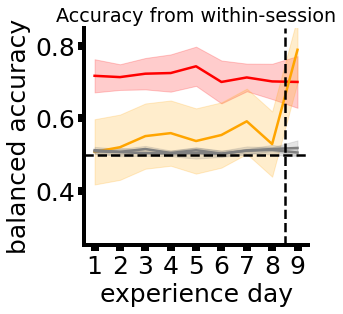

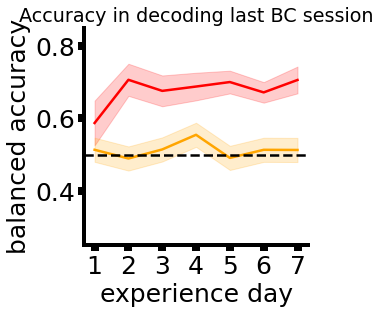

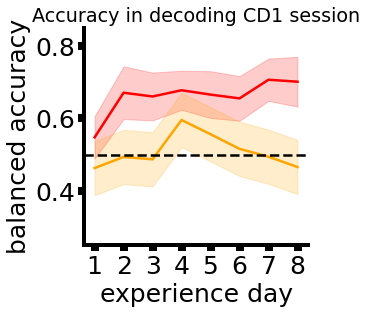

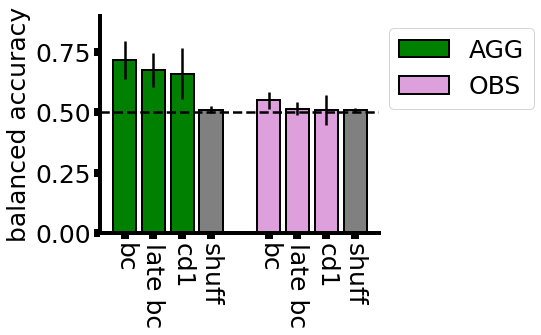

In [53]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})
err='ci'
averaging=np.median
### plot accuracies

# aggression / observation accuracy across time
plt.figure(figsize=(4, 4))
n=9
sessions2exclude=9 # 9 or -1
plt.title('Accuracy from within-session')
plt.plot(np.arange(n), averaging(agg_grid_scores[:sessions2exclude], axis=1), color='red', label='agg')
plt.fill_between(np.arange(n), averaging(agg_grid_scores[:sessions2exclude], axis=1)+error_values(agg_grid_scores[:sessions2exclude], err), averaging(agg_grid_scores[:sessions2exclude], axis=1)-error_values(agg_grid_scores[:sessions2exclude], err), 
                 color='red', alpha=0.2)
plt.plot(np.arange(n), averaging(obs_grid_scores[:sessions2exclude], axis=1), color='orange', label='obs')
plt.fill_between(np.arange(n), averaging(obs_grid_scores[:sessions2exclude], axis=1)+error_values(obs_grid_scores[:sessions2exclude], 'std'), averaging(obs_grid_scores[:sessions2exclude], axis=1)-error_values(obs_grid_scores[:sessions2exclude], 'std'), 
                 color='orange', alpha=0.2)
plt.plot(np.arange(n), averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1), color='grey', label='agg shuffle')
plt.fill_between(np.arange(n), averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1)+error_values(agg_shuffled_held_out_scores[:sessions2exclude], err), 
                 averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1)-error_values(agg_shuffled_held_out_scores[:sessions2exclude], err), color='grey', alpha=0.2)
plt.plot(np.arange(n), averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1), color='grey', label='obs shuffle')
plt.fill_between(np.arange(n), averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1)+error_values(obs_shuffled_held_out_scores[:sessions2exclude], err), 
                 averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1)-error_values(obs_shuffled_held_out_scores[:sessions2exclude], err), color='grey', alpha=0.2)
plt.axhline(0.5, linestyle='--', color='black')
sns.despine()
plt.xticks(np.arange(0, n), np.arange(1, n+1));
plt.axvline(7.5, linestyle='--', color='black') # hashtag out if cd1 not in plot
plt.xlabel('experience day')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.85, bottom=0.25)
# plt.legend(bbox_to_anchor=(1.0, 1.0))

###

# late aggression / observation relative to other days
plt.figure(figsize=(4, 4))
plt.title('Accuracy in decoding last BC session')
plt.plot(np.arange(7), averaging(agg_late_scores, axis=1), color='red', label='agg')
plt.fill_between(np.arange(7), averaging(agg_late_scores, axis=1)+error_values(agg_late_scores, err), averaging(agg_late_scores, axis=1)-error_values(agg_late_scores, err), color='red', alpha=0.2)
plt.plot(np.arange(7), averaging(obs_late_scores, axis=1), color='orange', label='obs')
plt.fill_between(np.arange(7), averaging(obs_late_scores, axis=1)+error_values(obs_late_scores, 'std'), averaging(obs_late_scores, axis=1)-error_values(obs_late_scores, 'std'), color='orange', alpha=0.2)
plt.axhline(0.5, linestyle='--', color='black')
sns.despine()
plt.xticks(np.arange(0, 7), np.arange(1, 8));
plt.xlabel('experience day')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.85, bottom=0.25)
# plt.legend(bbox_to_anchor=(1.0, 1.0))

###

# aggression / observation accuracies relative to cd1
plt.figure(figsize=(4, 4))
plt.title('Accuracy in decoding CD1 session')
plt.plot(np.arange(8), averaging(agg_cd1_scores, axis=1), color='red', label='agg')
plt.fill_between(np.arange(8), averaging(agg_cd1_scores, axis=1)+error_values(agg_cd1_scores, err), averaging(agg_cd1_scores, axis=1)-error_values(agg_cd1_scores, err), color='red', alpha=0.2)
plt.plot(np.arange(8), averaging(obs_cd1_scores, axis=1), color='orange', label='obs')
plt.fill_between(np.arange(8), averaging(obs_cd1_scores, axis=1)+error_values(obs_cd1_scores, 'std'), averaging(obs_cd1_scores, axis=1)-error_values(obs_cd1_scores, 'std'), color='orange', alpha=0.2)
plt.axhline(0.5, linestyle='--', color='black')
sns.despine()
plt.xticks(np.arange(0, 8), np.arange(1, 9));
plt.xlabel('experience day')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.85, bottom=0.25)
# plt.legend(bbox_to_anchor=(1.5, 1.0))

# summary bar plot of the all of the above
plt.figure(figsize=(5, 4))
plt.bar(0, np.mean(agg_grid_scores[:-1], axis=1).mean(), color='green', yerr=np.std(agg_grid_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2, label='AGG')
plt.bar(1, np.mean(agg_late_scores, axis=1).mean(), color='green', yerr=np.std(agg_late_scores, axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(2, np.mean(agg_cd1_scores, axis=1).mean(), color='green', yerr=np.std(agg_cd1_scores, axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(3, np.mean(agg_shuffled_held_out_scores[:-1], axis=1).mean(), color='grey', yerr=np.std(agg_shuffled_held_out_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(5, np.mean(obs_grid_scores[:-1], axis=1).mean(), color='plum', yerr=np.std(obs_grid_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2, label='OBS')
plt.bar(6, np.mean(obs_late_scores, axis=1).mean(), color='plum', yerr=np.std(obs_late_scores, axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(7, np.mean(obs_cd1_scores, axis=1).mean(), color='plum', yerr=np.std(obs_cd1_scores, axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(8, np.mean(obs_shuffled_held_out_scores[:-1], axis=1).mean(), color='grey', yerr=np.std(obs_shuffled_held_out_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.axhline(0.5, color='black', linestyle='--')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.90)
plt.xticks([0, 1, 2, 3, 5, 6, 7, 8], ['bc', 'late bc', 'cd1', 'shuff', 'bc', 'late bc', 'cd1', 'shuff'], rotation=270)
sns.despine()
plt.legend(bbox_to_anchor=(1.6, 1))





In [79]:

from statsmodels.stats.anova import AnovaRM

for scores_array, held_out_scores_array in zip([agg_grid_scores, obs_grid_scores, non_grid_scores], [agg_shuffled_held_out_scores, obs_shuffled_held_out_scores, non_shuffled_held_out_scores]):

    scores_array = scores_array[:-1]
    held_out_scores_array = held_out_scores_array[:-1]

    data = []
    for i in range(scores_array.shape[1]):
        for j in range(scores_array.shape[0]):
            data.append(['subject'+str(i+1), 'agg_grid_scores', scores_array[j, i]])
            data.append(['subject'+str(i+1), 'agg_shuffled_held_out_scores', held_out_scores_array[j, i]])

    df = pd.DataFrame(data, columns=['subject', 'condition', 'score'])

    # Aggregate the data by calculating the mean score for each subject-condition combination
    df = df.groupby(['subject', 'condition']).mean().reset_index()

    # Perform the repeated measures ANOVA
    anova = AnovaRM(df, 'score', 'subject', within=['condition'])
    res = anova.fit()

    print(res)

                 Anova
          F Value  Num DF  Den DF Pr > F
----------------------------------------
condition 172.1640 1.0000 11.0000 0.0000

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  6.6793 1.0000 3.0000 0.0815

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  0.3440 1.0000 3.0000 0.5987



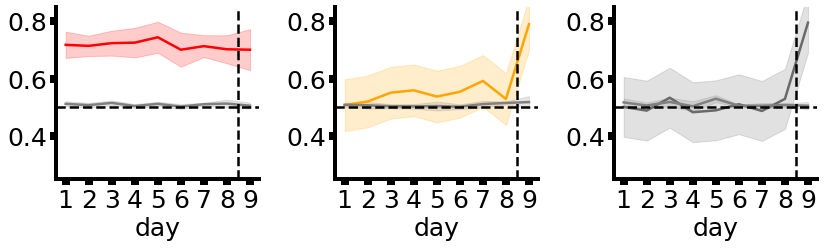

In [88]:
err='ci'
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Plot agg_grid_scores on the first subplot
axs[0].plot(np.arange(n), averaging(agg_grid_scores[:sessions2exclude], axis=1), color='red', label='agg')
axs[0].fill_between(np.arange(n), averaging(agg_grid_scores[:sessions2exclude], axis=1)+error_values(agg_grid_scores[:sessions2exclude], err), averaging(agg_grid_scores[:sessions2exclude], axis=1)-error_values(agg_grid_scores[:sessions2exclude], err), 
                 color='red', alpha=0.2)
axs[0].plot(np.arange(n), averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1), color='grey', label='agg shuffle')
axs[0].fill_between(np.arange(n), averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1)+error_values(agg_shuffled_held_out_scores[:sessions2exclude], err), 
                 averaging(agg_shuffled_held_out_scores[:sessions2exclude], axis=1)-error_values(agg_shuffled_held_out_scores[:sessions2exclude], err), color='grey', alpha=0.2)
axs[0].axhline(0.5, linestyle='--', color='black')
axs[0].set_xticks(np.arange(0, n))
axs[0].set_xticklabels(np.arange(1, n+1))
axs[0].set_xlabel('day')
axs[0].set_ylim(top=0.85, bottom=0.25)
axs[0].axvline(7.5, linestyle='--', color='black') # hashtag out if cd1 not in plot


# Plot obs_grid_scores on the second subplot
axs[1].plot(np.arange(n), averaging(obs_grid_scores[:sessions2exclude], axis=1), color='orange', label='obs')
axs[1].fill_between(np.arange(n), averaging(obs_grid_scores[:sessions2exclude], axis=1)+error_values(obs_grid_scores[:sessions2exclude], 'std'), averaging(obs_grid_scores[:sessions2exclude], axis=1)-error_values(obs_grid_scores[:sessions2exclude], 'std'), 
                 color='orange', alpha=0.2)
axs[1].plot(np.arange(n), averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1), color='grey', label='obs shuffle')
axs[1].fill_between(np.arange(n), averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1)+error_values(obs_shuffled_held_out_scores[:sessions2exclude], err), 
                 averaging(obs_shuffled_held_out_scores[:sessions2exclude], axis=1)-error_values(obs_shuffled_held_out_scores[:sessions2exclude], err), color='grey', alpha=0.2)
axs[1].axhline(0.5, linestyle='--', color='black')
axs[1].set_xticks(np.arange(0, n))
axs[1].set_xticklabels(np.arange(1, n+1))
axs[1].set_xlabel('day')
axs[1].set_ylim(top=0.85, bottom=0.25)
axs[1].axvline(7.5, linestyle='--', color='black') # hashtag out if cd1 not in plot

# Plot obs_grid_scores on the second subplot
axs[2].plot(np.arange(n), averaging(non_grid_scores[:sessions2exclude], axis=1), color='dimgray', label='obs')
axs[2].fill_between(np.arange(n), averaging(non_grid_scores[:sessions2exclude], axis=1)+error_values(non_grid_scores[:sessions2exclude], 'std'), averaging(non_grid_scores[:sessions2exclude], axis=1)-error_values(non_grid_scores[:sessions2exclude], 'std'), 
                 color='dimgray', alpha=0.2)
axs[2].plot(np.arange(n), averaging(non_shuffled_held_out_scores[:sessions2exclude], axis=1), color='grey', label='obs shuffle')
axs[2].fill_between(np.arange(n), averaging(non_shuffled_held_out_scores[:sessions2exclude], axis=1)+error_values(non_shuffled_held_out_scores[:sessions2exclude], err), 
                 averaging(non_shuffled_held_out_scores[:sessions2exclude], axis=1)-error_values(non_shuffled_held_out_scores[:sessions2exclude], err), color='grey', alpha=0.2)
axs[2].axhline(0.5, linestyle='--', color='black')
axs[2].set_xticks(np.arange(0, n))
axs[2].set_xticklabels(np.arange(1, n+1))
axs[2].set_xlabel('day')
axs[2].set_ylim(top=0.85, bottom=0.25)
axs[2].axvline(7.5, linestyle='--', color='black') # hashtag out if cd1 not in plot

sns.despine()
plt.tight_layout()  
# plt.savefig('.\\retreat_figs\\accuracy_within.svg', dpi=300, bbox_inches='tight')

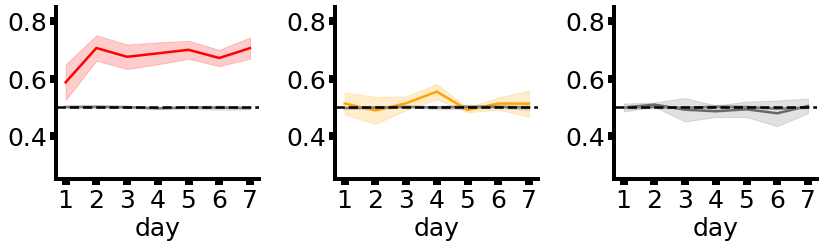

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with three subplots

# Plot agg_late_scores on the first subplot
axs[0].plot(np.arange(7), averaging(agg_late_scores, axis=1), color='red', label='agg')
axs[0].fill_between(np.arange(7), averaging(agg_late_scores, axis=1)+error_values(agg_late_scores, err), averaging(agg_late_scores, axis=1)-error_values(agg_late_scores, err), color='red', alpha=0.2)
axs[0].plot(np.arange(7), averaging(agg_late_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[0].fill_between(np.arange(7), averaging(agg_late_shuffled_held_out_scores, axis=1)+error_values(agg_late_shuffled_held_out_scores, err), averaging(agg_late_shuffled_held_out_scores, axis=1)-error_values(agg_late_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[0].axhline(0.5, linestyle='--', color='black')
axs[0].set_xticks(np.arange(0, 7), np.arange(1, 8));
axs[0].set_xlabel('day')
axs[0].set_ylim(top=0.85, bottom=0.25)
# Plot obs_late_scores on the second subplot
axs[1].plot(np.arange(7), averaging(obs_late_scores, axis=1), color='orange', label='obs')
axs[1].fill_between(np.arange(7), averaging(obs_late_scores, axis=1)+error_values(obs_late_scores, err), averaging(obs_late_scores, axis=1)-error_values(obs_late_scores, err), color='orange', alpha=0.2)
axs[1].plot(np.arange(7), averaging(obs_late_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[1].fill_between(np.arange(7), averaging(obs_late_shuffled_held_out_scores, axis=1)+error_values(obs_late_shuffled_held_out_scores, err), averaging(obs_late_shuffled_held_out_scores, axis=1)-error_values(obs_late_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[1].axhline(0.5, linestyle='--', color='black')
axs[1].set_xticks(np.arange(0, 7), np.arange(1, 8));
axs[1].set_xlabel('day')
axs[1].set_ylim(top=0.85, bottom=0.25)
# Plot non_late_scores on the third subplot
axs[2].plot(np.arange(7), averaging(non_late_scores, axis=1), color='dimgray', label='non')
axs[2].fill_between(np.arange(7), averaging(non_late_scores, axis=1)+error_values(non_late_scores, err), averaging(non_late_scores, axis=1)-error_values(non_late_scores, err), color='dimgray', alpha=0.2)
axs[2].plot(np.arange(7), averaging(non_late_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[2].fill_between(np.arange(7), averaging(non_late_shuffled_held_out_scores, axis=1)+error_values(non_late_shuffled_held_out_scores, err), averaging(non_late_shuffled_held_out_scores, axis=1)-error_values(non_late_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[2].axhline(0.5, linestyle='--', color='black')
axs[2].set_xticks(np.arange(0, 7), np.arange(1, 8));
axs[2].set_xlabel('day')
axs[2].set_ylim(top=0.85, bottom=0.25)

sns.despine()
plt.tight_layout() 
plt.savefig('.\\retreat_figs\\accuracy_late.svg', dpi=300, bbox_inches='tight')

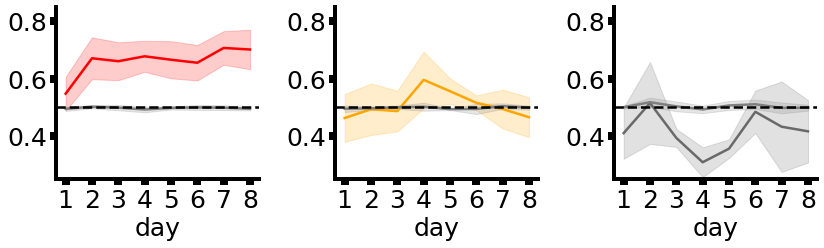

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with three subplots

# Plot agg_cd1_scores on the first subplot
axs[0].plot(np.arange(8), averaging(agg_cd1_scores, axis=1), color='red', label='agg')
axs[0].fill_between(np.arange(8), averaging(agg_cd1_scores, axis=1)+error_values(agg_cd1_scores, err), averaging(agg_cd1_scores, axis=1)-error_values(agg_cd1_scores, err), color='red', alpha=0.2)
axs[0].plot(np.arange(8), averaging(agg_cd1_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[0].fill_between(np.arange(8), averaging(agg_cd1_shuffled_held_out_scores, axis=1)+error_values(agg_cd1_shuffled_held_out_scores, err), averaging(agg_cd1_shuffled_held_out_scores, axis=1)-error_values(agg_cd1_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[0].axhline(0.5, linestyle='--', color='black')
axs[0].set_xticks(np.arange(0, 8), np.arange(1, 9));
axs[0].set_xlabel('day')
axs[0].set_ylim(top=0.85, bottom=0.25)
# Plot obs_cd1_scores on the second subplot
axs[1].plot(np.arange(8), averaging(obs_cd1_scores, axis=1), color='orange', label='obs')
axs[1].fill_between(np.arange(8), averaging(obs_cd1_scores, axis=1)+error_values(obs_cd1_scores, err), averaging(obs_cd1_scores, axis=1)-error_values(obs_cd1_scores, err), color='orange', alpha=0.2)
axs[1].plot(np.arange(8), averaging(obs_cd1_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[1].fill_between(np.arange(8), averaging(obs_cd1_shuffled_held_out_scores, axis=1)+error_values(obs_cd1_shuffled_held_out_scores, err), averaging(obs_cd1_shuffled_held_out_scores, axis=1)-error_values(obs_cd1_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[1].axhline(0.5, linestyle='--', color='black')
axs[1].set_xticks(np.arange(0, 8), np.arange(1, 9));
axs[1].set_xlabel('day')
axs[1].set_ylim(top=0.85, bottom=0.25)
# Plot non_cd1_scores on the third subplot
axs[2].plot(np.arange(8), averaging(non_cd1_scores, axis=1), color='dimgray', label='non')
axs[2].fill_between(np.arange(8), averaging(non_cd1_scores, axis=1)+error_values(non_cd1_scores, err), averaging(non_cd1_scores, axis=1)-error_values(non_cd1_scores, err), color='dimgray', alpha=0.2)
axs[2].plot(np.arange(8), averaging(non_cd1_shuffled_held_out_scores, axis=1), color='gray', label='agg')
axs[2].fill_between(np.arange(8), averaging(non_cd1_shuffled_held_out_scores, axis=1)+error_values(non_cd1_shuffled_held_out_scores, err), averaging(non_cd1_shuffled_held_out_scores, axis=1)-error_values(non_cd1_shuffled_held_out_scores, err), color='gray', alpha=0.2)
axs[2].axhline(0.5, linestyle='--', color='black')
axs[2].set_xticks(np.arange(0, 8), np.arange(1, 9));
axs[2].set_xlabel('day')
axs[2].set_ylim(top=0.85, bottom=0.25)

sns.despine()
plt.tight_layout() 
plt.savefig('.\\retreat_figs\\accuracy_cd1.svg', dpi=300, bbox_inches='tight')

### Run decoder while performing feature importance

Feature importance testing done in circuit-wide manner (removing all E circuits vs removing all I circuits)

In [93]:
def extract_circuit_indices(current_regions):
    E_indices = [i for i, reg in enumerate(current_regions) if '(E)' in reg or '(DA)' in reg]
    I_indices = [i for i, reg in enumerate(current_regions) if '(I)' in reg or '(DA)' in reg]
    return E_indices, I_indices

def run_KNN_w_KOs(new_data, animals, binary_labels):
    
    '''
    same as function above but knocks out whole E vs I circuits
    '''
    
    # For saving baseline scores
    perm_grid_scores = np.zeros((9, 2, len(animals)))
    perm_grid_scores[:] = np.nan
    perm_held_out_scores = perm_grid_scores.copy()
    perm_shuffled_held_out_scores = perm_grid_scores.copy()

    # For predicting on last BC
    perm_late_scores = np.zeros((7, 2, len(animals)))
    perm_late_scores[:] = np.nan
    perm_late_f1s = np.zeros((7, 2, len(animals)))
    perm_late_f1s[:] = np.nan
    
    # For predicting on CD1
    perm_cd1_scores = np.zeros((8, 2, len(animals)))
    perm_cd1_scores[:] = np.nan
    perm_cd1_f1s = np.zeros((8, 2, len(animals)))
    perm_cd1_f1s[:] = np.nan

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        if a <= 11:
            exp='aggression'
        elif a<=15:
            exp='observation'
        else:
            exp='nonsocial'

        # load animal data
        trial_comps, _, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]
        E_indices, I_indices = extract_circuit_indices(rois)
        print(E_indices, I_indices)

        for e, epoch in enumerate(trial_comps):

            print('Beginning epoch %i for animal %s' % (e, animal))

            # Divide data into inputs and outputs
            X, y = produce_XY(epoch)

            # Perform random undersampling to balance the classes
            rus = RandomUnderSampler(random_state=42)
            X_resampled, y_resampled = rus.fit_resample(X, y)
            
            for idx, n in enumerate([E_indices, I_indices]):
            
                # Do feature-dependent shuffle
                X_perm = X_resampled.copy()
                column_to_shuffle = X_perm[:, n]
                np.random.shuffle(column_to_shuffle)
                X_perm[:, n] = column_to_shuffle

                # Create a KNN classifier
                knn_classifier = KNeighborsClassifier()

                # Define a grid of hyperparameters to search
                param_grid = {
                    'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                    'weights': ['uniform', 'distance'],  # Weighting strategy
                    'metric': ['euclidean', 'manhattan']  # Distance metric
                }


                # Create a GridSearchCV object with balanced accuracy as the scoring metric
                grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

                # Perform the grid search on your data
                grid_search.fit(X_perm, y_resampled)
                best_model = grid_search.best_estimator_

                # Print the best parameters and best balanced accuracy score
                print("Best Parameters (XVAL):", grid_search.best_params_)
                score = grid_search.best_score_
                perm_grid_scores[e, idx, a] = score
                print("Best Balanced Accuracy (XVAL):", score)

                # Print scores on shuffled set
                grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
                X_shuf = X_resampled.copy()
                np.random.shuffle(X_shuf)
                grid_search.fit(X_shuf, y_resampled)
                score = grid_search.best_score_
                print("Best Shuffled Accuracy (XVAL):", score)
                perm_shuffled_held_out_scores[e, idx, a] = score

                if e in [0, 1, 2, 3, 4, 5, 6]:
                    # Print scores using late held out set
                    X_late, y_late = produce_XY(trial_comps[-2])
                    y_pred = best_model.predict(X_late)
                    score = balanced_accuracy_score(y_late, y_pred)
                    perm_late_scores[e, idx, a] = score
                    print("Best Balanced Accuracy (late):", score)
                    score = f1_score(y_late, y_pred, average='weighted')
                    perm_late_f1s[e, idx, a] = score
                    print("Best F1 score (late):", score)

                if e != 8:
                    # Print scores using CD1 held out set
                    X_cd1, y_cd1 = produce_XY(trial_comps[-1])
                    y_pred = best_model.predict(X_cd1)
                    score = balanced_accuracy_score(y_cd1, y_pred)
                    perm_cd1_scores[e, idx, a] = score
                    print("Best Balanced Accuracy (cd1):", score)
                    score = f1_score(y_cd1, y_pred, average='weighted')
                    perm_cd1_f1s[e,idx,  a] = score
                    print("Best F1 score (cd1):", score)
                    
    return perm_grid_scores, perm_shuffled_held_out_scores, perm_late_scores, perm_late_f1s, perm_cd1_scores, perm_cd1_f1s

perm_grid_scores, perm_shuffled_held_out_scores, perm_late_scores, perm_late_f1s, perm_cd1_scores, perm_cd1_f1s = run_KNN_w_KOs(new_data, animals, 'aggression labels') # aggro experience


Processing data for 3095
[0, 2, 4, 6, 8, 10] [1, 3, 5, 7, 9, 11]
Beginning epoch 0 for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6662197941641197
Best Shuffled Accuracy (XVAL): 0.5228499789527628
Best Balanced Accuracy (late): 0.543289956265905
Best F1 score (late): 0.8877740210912277
Best Balanced Accuracy (cd1): 0.5539211263825592
Best F1 score (cd1): 0.9247774594728728
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6990153553322718
Best Shuffled Accuracy (XVAL): 0.5149770920648865
Best Balanced Accuracy (late): 0.4996717442345117
Best F1 score (late): 0.8081092140001825
Best Balanced Accuracy (cd1): 0.49681505146586974
Best F1 score (cd1): 0.8572125409485333
Beginning epoch 1 for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.5742367

In [98]:
agg_perm_grid_scores, agg_perm_shuffled_held_out_scores, agg_perm_late_scores, agg_perm_late_f1s, agg_perm_cd1_scores,agg_perm_cd1_f1s = perm_grid_scores[:, :, :12], perm_shuffled_held_out_scores[:, :, :12], perm_late_scores[:, :, :12], perm_late_f1s[:, :, :12], perm_cd1_scores[:, :, :12], perm_cd1_f1s[:, :, :12]
obs_perm_grid_scores, obs_perm_shuffled_held_out_scores, obs_perm_late_scores, obs_perm_late_f1s, obs_perm_cd1_scores, obs_perm_cd1_f1s = perm_grid_scores[:, :, 12:16], perm_shuffled_held_out_scores[:, :, 12:16], perm_late_scores[:, :, 12:16], perm_late_f1s[:, :, 12:16], perm_cd1_scores[:, :, 12:16], perm_cd1_f1s[:, :, 12:16]
non_perm_grid_scores, non_perm_shuffled_held_out_scores, non_perm_late_scores, non_perm_late_f1s, non_perm_cd1_scores, non_perm_cd1_f1s = perm_grid_scores[:, :, 16:], perm_shuffled_held_out_scores[:, :, 16:], perm_late_scores[:, :, 16:], perm_late_f1s[:, :, 16:], perm_cd1_scores[:, :, 16:], perm_cd1_f1s[:, :, 16:]

In [99]:
# compute accuracy differentials
agg_grid_score_diff = np.zeros((agg_perm_grid_scores.shape))
agg_grid_score_diff[:, 0, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 0, :]) / agg_grid_scores) * 100
agg_grid_score_diff[:, 1, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 1, :]) / agg_grid_scores) * 100
agg_grid_score_diff = np.where(agg_grid_score_diff < 0, 0, agg_grid_score_diff)

obs_grid_score_diff = np.zeros((obs_perm_grid_scores.shape))
obs_grid_score_diff[:, 0, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 0, :]) / obs_grid_scores) * 100
obs_grid_score_diff[:, 1, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 1, :]) / obs_grid_scores) * 100
obs_grid_score_diff = np.where(obs_grid_score_diff < 0, 0, obs_grid_score_diff)

non_grid_score_diff = np.zeros((non_perm_grid_scores.shape))
non_grid_score_diff[:, 0, :] = ((non_grid_scores - non_perm_grid_scores[:, 0, :]) / non_grid_scores) * 100
non_grid_score_diff[:, 1, :] = ((non_grid_scores - non_perm_grid_scores[:, 1, :]) / non_grid_scores) * 100
non_grid_score_diff = np.where(non_grid_score_diff < 0, 0, non_grid_score_diff)


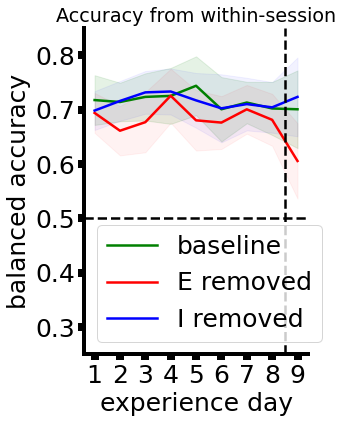

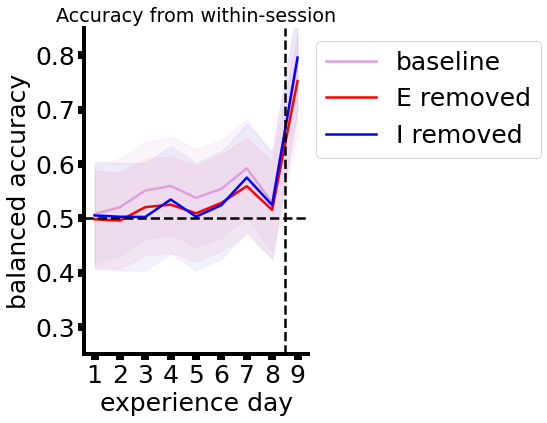

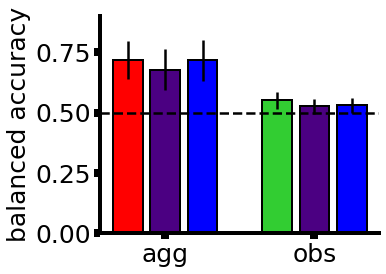

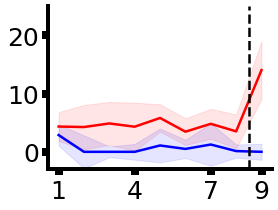

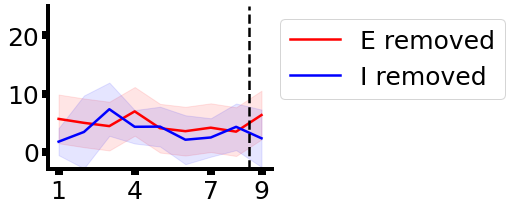

In [100]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

### plot accuracies

# AGG
n = 9 # 8 or 9
sessions2exclude=9 # -1 or 9
plt.figure(figsize=(4, 6))
plt.title('Accuracy from within-session')
plt.plot(np.arange(n), np.nanmedian(agg_grid_scores[:sessions2exclude], axis=1), color='green', label='baseline')
plt.fill_between(np.arange(n), np.nanmedian(agg_grid_scores[:sessions2exclude], axis=1)+error_values(agg_grid_scores[:sessions2exclude], 'ci'), np.nanmedian(agg_grid_scores[:sessions2exclude], axis=1)-error_values(agg_grid_scores[:sessions2exclude], 'ci'), 
                 color='green', alpha=0.1)
plt.plot(np.arange(n), np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 0, :], axis=1), color='red', label='E removed')
plt.fill_between(np.arange(n), np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 0, :], axis=1)+error_values(agg_perm_grid_scores[:sessions2exclude, 0, :], 'ci'), 
                 np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 0, :], axis=1)-error_values(agg_perm_grid_scores[:sessions2exclude, 0, :], 'ci'), 
                 color='red', alpha=0.05)
plt.plot(np.arange(n), np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 1, :], axis=1), color='blue', label='I removed')
plt.fill_between(np.arange(n), np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 1, :], axis=1)+error_values(agg_perm_grid_scores[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(agg_perm_grid_scores[:sessions2exclude, 1, :], axis=1)-error_values(agg_perm_grid_scores[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.05)
plt.axhline(0.5, linestyle='--', color='black')
sns.despine()
plt.xticks(np.arange(n), np.arange(1, n+1));
plt.xlabel('experience day')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.85, bottom=0.25)
plt.legend()
plt.axvline(7.5, color='black', linestyle='--')

# OBS
plt.figure(figsize=(4, 6))
plt.title('Accuracy from within-session')
plt.plot(np.arange(0, n), np.nanmedian(obs_grid_scores[:sessions2exclude], axis=1), color='plum', label='baseline')
plt.fill_between(np.arange(n), np.nanmedian(obs_grid_scores[:sessions2exclude], axis=1)+error_values(obs_grid_scores[:sessions2exclude], 'std'), 
                 np.nanmedian(obs_grid_scores[:sessions2exclude], axis=1)-error_values(obs_grid_scores[:sessions2exclude], 'std'), 
                 color='plum', alpha=0.1)
plt.plot(np.arange(0, n), np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 0, :], axis=1), color='red', label='E removed')
plt.fill_between(np.arange(n), np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 0, :], axis=1)+error_values(obs_perm_grid_scores[:sessions2exclude, 0, :], 'std'), 
                 np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 0, :], axis=1)-error_values(obs_perm_grid_scores[:sessions2exclude, 0, :], 'std'), 
                 color='red', alpha=0.05)
plt.plot(np.arange(0, n), np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 1, :], axis=1), color='blue', label='I removed')
plt.fill_between(np.arange(n), np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 1, :], axis=1)+error_values(obs_perm_grid_scores[:sessions2exclude, 1, :], 'std'), 
                 np.nanmedian(obs_perm_grid_scores[:sessions2exclude, 1, :], axis=1)-error_values(obs_perm_grid_scores[:sessions2exclude, 1, :], 'std'), 
                 color='blue', alpha=0.05)
plt.axhline(0.5, linestyle='--', color='black')
sns.despine()
plt.xticks(np.arange(n), np.arange(1, n+1));
plt.xlabel('experience day')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.85, bottom=0.25)
plt.legend(bbox_to_anchor=(2.1, 1))
plt.axvline(7.5, color='black', linestyle='--')

### summary of the above

plt.figure(figsize=(5, 4))
plt.bar(0, np.mean(agg_grid_scores[:-1], axis=1).mean(), color='red', yerr=np.std(agg_grid_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(1, np.mean(agg_perm_grid_scores[:, 0, :], axis=1).mean(), color='indigo', yerr=np.std(agg_perm_grid_scores[:, 0, :], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(2, np.mean(agg_perm_grid_scores[:, 1, :], axis=1).mean(), color='blue', yerr=np.std(agg_perm_grid_scores[:, 0, :], axis=1).mean(), 
       edgecolor='black', linewidth=2)

plt.bar(4, np.mean(obs_grid_scores[:-1], axis=1).mean(), color='limegreen', yerr=np.std(obs_grid_scores[:-1], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(5, np.mean(obs_perm_grid_scores[:-1, 0, :], axis=1).mean(), color='indigo', yerr=np.std(obs_perm_grid_scores[:-1, 0, :], axis=1).mean(), 
       edgecolor='black', linewidth=2)
plt.bar(6, np.mean(obs_perm_grid_scores[:-1, 1, :], axis=1).mean(), color='blue', yerr=np.std(obs_perm_grid_scores[:-1, 0, :], axis=1).mean(), 
       edgecolor='black', linewidth=2)

plt.axhline(0.5, color='black', linestyle='--')
plt.ylabel('balanced accuracy')
plt.ylim(top=0.90)
plt.xticks([1, 5], ['agg', 'obs'])
sns.despine()

### plot % diff

# AGG
plt.figure(figsize=(4, 3))
# plt.title('Accuracy from within-session')
plt.plot(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1), color='red', label='agg')
plt.fill_between(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1)+error_values(agg_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1)-error_values(agg_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 color='red', alpha=0.1)

plt.plot(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1), color='blue', label='agg')
plt.fill_between(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1)+error_values(agg_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1)-error_values(agg_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.1)

sns.despine()
# plt.ylabel('% accuracy change')
# plt.xlabel('experience day')
# plt.title('AGG')
plt.axvline(7.5, color='black', linestyle='--')
plt.ylim(top=25, bottom=-3)
plt.xticks([0, 3, 6, 8], [1, 4, 7, 9]);
# plt.savefig('AGG_KOs.png', dpi=600, bbox_inches='tight')

# OBS
plt.figure(figsize=(4, 3))
# plt.title('Accuracy from within-session')
plt.plot(np.arange(0, n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1), color='red', label='E removed')
plt.fill_between(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1)+error_values(obs_grid_score_diff[:sessions2exclude, 0, :], 'std'), 
                 np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1)-error_values(obs_grid_score_diff[:sessions2exclude, 0, :], 'std'), 
                 color='red', alpha=0.1)

plt.plot(np.arange(0, n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1), color='blue', label='I removed')
plt.fill_between(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1)+error_values(obs_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1)-error_values(obs_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.1)
plt.axvline(7.5, color='black', linestyle='--')
sns.despine()
# plt.ylabel('% accuracy change')
# plt.xlabel('experience day')
# plt.title('OBS')
plt.ylim(top=25, bottom=-3)
plt.legend(bbox_to_anchor=(2.1, 1))
plt.xticks([0, 3, 6, 8], [1, 4, 7, 9]);
# plt.savefig('OBS_KOs.png', dpi=600, bbox_inches='tight')



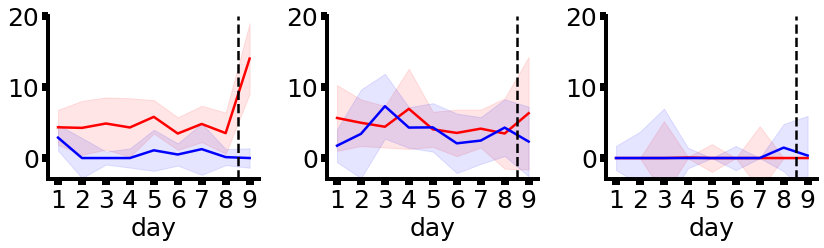

In [114]:
# AGG
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1), color='red', label='agg')
axs[0].fill_between(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1)+error_values(agg_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 np.nanmedian(agg_grid_score_diff[:sessions2exclude, 0, :], axis=1)-error_values(agg_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 color='red', alpha=0.1)
axs[0].plot(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1), color='blue', label='agg')
axs[0].fill_between(np.arange(n), np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1)+error_values(agg_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(agg_grid_score_diff[:sessions2exclude, 1, :], axis=1)-error_values(agg_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.1)
axs[0].axvline(7.5, color='black', linestyle='--')
axs[0].set_ylim(top=20, bottom=-3)
axs[0].set_xticks(np.arange(0, n))
axs[0].set_xticklabels(np.arange(1, n+1))
axs[0].set_xlabel('day')

axs[1].plot(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1), color='red', label='agg')
axs[1].fill_between(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1)+error_values(obs_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 np.nanmedian(obs_grid_score_diff[:sessions2exclude, 0, :], axis=1)-error_values(obs_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 color='red', alpha=0.1)
axs[1].plot(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1), color='blue', label='agg')
axs[1].fill_between(np.arange(n), np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1)+error_values(obs_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(obs_grid_score_diff[:sessions2exclude, 1, :], axis=1)-error_values(obs_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.1)
axs[1].axvline(7.5, color='black', linestyle='--')
axs[1].set_ylim(top=20, bottom=-3)
axs[1].set_xticks(np.arange(0, n))
axs[1].set_xticklabels(np.arange(1, n+1))
axs[1].set_xlabel('day')

axs[2].plot(np.arange(n), np.nanmedian(non_grid_score_diff[:sessions2exclude, 0, :], axis=1), color='red', label='agg')
axs[2].fill_between(np.arange(n), np.nanmedian(non_grid_score_diff[:sessions2exclude, 0, :], axis=1)+error_values(non_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 np.nanmedian(non_grid_score_diff[:sessions2exclude, 0, :], axis=1)-error_values(non_grid_score_diff[:sessions2exclude, 0, :], 'ci'), 
                 color='red', alpha=0.1)
axs[2].plot(np.arange(n), np.nanmedian(non_grid_score_diff[:sessions2exclude, 1, :], axis=1), color='blue', label='agg')
axs[2].fill_between(np.arange(n), np.nanmedian(non_grid_score_diff[:sessions2exclude, 1, :], axis=1)+error_values(non_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 np.nanmedian(non_grid_score_diff[:sessions2exclude, 1, :], axis=1)-error_values(non_grid_score_diff[:sessions2exclude, 1, :], 'ci'), 
                 color='blue', alpha=0.1)
axs[2].axvline(7.5, color='black', linestyle='--')
axs[2].set_ylim(top=20, bottom=-3)
axs[2].set_xticks(np.arange(0, n))
axs[2].set_xticklabels(np.arange(1, n+1))
axs[2].set_xlabel('day')

sns.despine()
plt.tight_layout()  
plt.savefig('.\\retreat_figs\\decoding_accuracy_diff.svg', dpi=300, bbox_inches='tight')

In [113]:

from statsmodels.stats.anova import AnovaRM

for scores_array, held_out_scores_array in zip([agg_grid_score_diff[:, 0, :], obs_grid_score_diff[:, 0, :], non_grid_score_diff[:, 0, :]], [agg_grid_score_diff[:, 1, :], obs_grid_score_diff[:, 1, :], non_grid_score_diff[:, 1, :]]):

    scores_array = scores_array[:-1]
    held_out_scores_array = held_out_scores_array[:-1]

    data = []
    for i in range(scores_array.shape[1]):
        for j in range(scores_array.shape[0]):
            data.append(['subject'+str(i+1), 'exc_scores', scores_array[j, i]])
            data.append(['subject'+str(i+1), 'inh_scores', held_out_scores_array[j, i]])

    df = pd.DataFrame(data, columns=['subject', 'condition', 'score'])

    # Aggregate the data by calculating the mean score for each subject-condition combination
    df = df.groupby(['subject', 'condition']).mean().reset_index()

    # Perform the repeated measures ANOVA
    anova = AnovaRM(df, 'score', 'subject', within=['condition'])
    res = anova.fit()

    print(res)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 16.3551 1.0000 11.0000 0.0019

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  0.0583 1.0000 3.0000 0.8248

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition  1.1088 1.0000 3.0000 0.3697



In [172]:
# compute accuracy differentials
agg_grid_score_diff = np.zeros((agg_perm_grid_scores.shape))
agg_grid_score_diff[:, 0, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 0, :]) / agg_grid_scores) * 100
agg_grid_score_diff[:, 1, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 1, :]) / agg_grid_scores) * 100
agg_grid_score_diff = np.where(agg_grid_score_diff < 0, 0, agg_grid_score_diff)
agg_grid_score_diff_train = np.nanmean(agg_grid_score_diff[:-1], axis=0)
agg_grid_score_diff_test = agg_grid_score_diff[-1]

obs_grid_score_diff = np.zeros((obs_perm_grid_scores.shape))
obs_grid_score_diff[:, 0, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 0, :]) / obs_grid_scores) * 100
obs_grid_score_diff[:, 1, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 1, :]) / obs_grid_scores) * 100
obs_grid_score_diff = np.where(obs_grid_score_diff < 0, 0, obs_grid_score_diff)
obs_grid_score_diff_train = np.nanmean(obs_grid_score_diff[:-1], axis=0)
obs_grid_score_diff_test = obs_grid_score_diff[-1]


non_grid_score_diff = np.zeros((non_perm_grid_scores.shape))
non_grid_score_diff[:, 0, :] = ((non_grid_scores - non_perm_grid_scores[:, 0, :]) / non_grid_scores) * 100
non_grid_score_diff[:, 1, :] = ((non_grid_scores - non_perm_grid_scores[:, 1, :]) / non_grid_scores) * 100
non_grid_score_diff = np.where(non_grid_score_diff < 0, 0, non_grid_score_diff)
non_grid_score_diff_train = np.nanmean(non_grid_score_diff[:-1], axis=0)
non_grid_score_diff_test = non_grid_score_diff[-1]


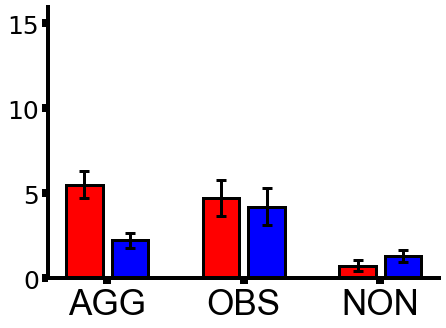

In [182]:
plt.figure(figsize=(7, 5))
plt.bar(0, agg_grid_score_diff_train[0].mean(), color='red', yerr=sem(agg_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(1, agg_grid_score_diff_train[1].mean(), color='blue', yerr=sem(agg_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.bar(3, obs_grid_score_diff_train[0].mean(), color='red', yerr=sem(obs_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(4, obs_grid_score_diff_train[1].mean(), color='blue', yerr=sem(obs_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.bar(6, non_grid_score_diff_train[0].mean(), color='red', yerr=sem(non_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(7, non_grid_score_diff_train[1].mean(), color='blue', yerr=sem(non_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.ylim(top=16)

plt.xticks([0.5, 3.5, 6.5], ['AGG', 'OBS', 'NON'], fontsize=35, fontfamily='Arial')
sns.despine()
plt.savefig('.\\retreat_figs\\decoding_accuracy_diff_train.svg', dpi=300, bbox_inches='tight')

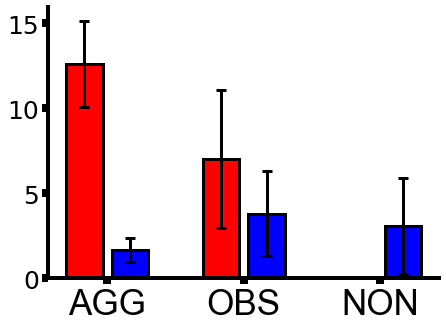

In [184]:
plt.figure(figsize=(7, 5))
plt.bar(0, agg_grid_score_diff_test[0].mean(), color='red', yerr=sem(agg_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(1, agg_grid_score_diff_test[1].mean(), color='blue', yerr=sem(agg_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.bar(3, obs_grid_score_diff_test[0].mean(), color='red', yerr=sem(obs_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(4, obs_grid_score_diff_test[1].mean(), color='blue', yerr=sem(obs_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.bar(6, non_grid_score_diff_test[0].mean(), color='red', yerr=sem(non_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(7, non_grid_score_diff_test[1].mean(), color='blue', yerr=sem(non_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.ylim(top=16)

plt.xticks([0.5, 3.5, 6.5], ['AGG', 'OBS', 'NON'], fontsize=35, fontfamily='Arial')
sns.despine()
plt.savefig('.\\retreat_figs\\decoding_accuracy_diff_test.svg', dpi=300, bbox_inches='tight')

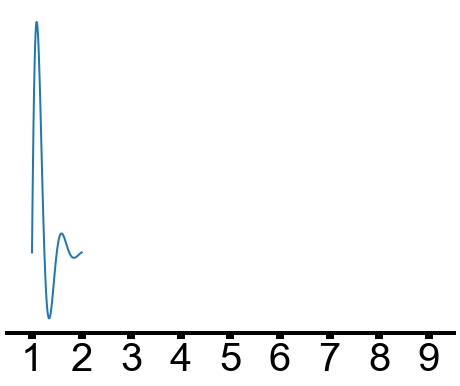

In [200]:
# Create a line
x = np.linspace(0, 1, 100)
y = np.sin(4 * np.pi * x) * np.exp(-5 * x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, linewidth=2)

# Set the number of ticks on the x-axis
plt.xticks(np.arange(9), np.arange(1, 10), fontfamily='Arial', fontsize=40)
plt.yticks([])
plt.xlim(-0.5, 8.5)
sns.despine(left=True)
plt.savefig('.\\retreat_figs\\lineplot.svg', dpi=300, bbox_inches='tight')

Repeat above but with model trained on all BC data

In [78]:
def run_KNN_w_KOs_all_data(new_data, animals, binary_labels, exp):
    
    '''
    same as function above but knocks out whole E vs I circuits
    '''
    
    # For saving baseline scores
    perm_grid_scores = np.zeros((3, len(animals)))
    perm_grid_scores[:] = np.nan
    perm_held_out_scores = perm_grid_scores.copy()
    perm_shuffled_held_out_scores = perm_grid_scores.copy()

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        # load animal data
        trial_comps, all_traces, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]
        E_indices, I_indices = extract_circuit_indices(rois)

        print('Beginning decoding for animal %s' % animal)

        # Divide data into inputs and outputs
        X, y = produce_XY(all_traces)

        # Perform random undersampling to balance the classes
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)

        for idx, n in enumerate([np.arange(len(rois)), E_indices, I_indices]):

            # Do feature-dependent shuffle
            if idx==0:
                X_perm=X_resampled.copy()
            else:
                X_perm = X_resampled.copy()
                column_to_shuffle = X_perm[:, n]
                np.random.shuffle(column_to_shuffle)
                X_perm[:, n] = column_to_shuffle

            # Create a KNN classifier
            knn_classifier = KNeighborsClassifier()

            # Define a grid of hyperparameters to search
            param_grid = {
                'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                'weights': ['uniform', 'distance'],  # Weighting strategy
                'metric': ['euclidean', 'manhattan']  # Distance metric
            }


            # Create a GridSearchCV object with balanced accuracy as the scoring metric
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

            # Perform the grid search on your data
            grid_search.fit(X_perm, y_resampled)
            best_model = grid_search.best_estimator_

            # Print the best parameters and best balanced accuracy score
            print("Best Parameters (XVAL):", grid_search.best_params_)
            score = grid_search.best_score_
            perm_grid_scores[idx, a] = score
            print("Best Balanced Accuracy (XVAL):", score)

            # Print scores on shuffled set
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
            X_shuf = X_resampled.copy()
            np.random.shuffle(X_shuf)
            grid_search.fit(X_shuf, y_resampled)
            score = grid_search.best_score_
            print("Best Shuffled Accuracy (XVAL):", score)
            perm_shuffled_held_out_scores[idx, a] = score

    return perm_grid_scores, perm_shuffled_held_out_scores

agg_full_perm_grid_scores, agg_full_perm_shuffled_held_out_scores = run_KNN_w_KOs_all_data(new_data, agg_animals, 'aggression labels', 'aggression') # aggro experience
obs_full_perm_grid_scores, obs_full_perm_shuffled_held_out_scores = run_KNN_w_KOs_all_data(new_data, obs_animals, 'aggression labels', 'observation') # obs experience

Processing data for 3095
Beginning decoding for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6782721635662812
Best Shuffled Accuracy (XVAL): 0.5076671694318753
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.6215015920898274
Best Shuffled Accuracy (XVAL): 0.4986173956762192
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.6977543154013741
Best Shuffled Accuracy (XVAL): 0.5062426680073738
Processing data for 3096
Beginning decoding for animal 3096
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.7466497659323074
Best Shuffled Accuracy (XVAL): 0.4984168025206523
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.702315

Best Shuffled Accuracy (XVAL): 0.5023476302837365
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.5235524949106551
Best Shuffled Accuracy (XVAL): 0.5015657957134971
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.5869473834189886
Best Shuffled Accuracy (XVAL): 0.5072576899158818


In [123]:
from scipy import stats

# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(array1, array2, alternative='greater')

# Check the p-value against your chosen significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Array 1 is statistically greater than Array 2.")
else:
    print("There is no statistically significant difference between the two arrays.")

array([0.        , 0.97883545, 3.39782201, 0.        , 0.        ,
       0.        , 0.        , 1.75990558, 0.        , 0.        ,
       0.        , 0.        ])

In [126]:
# do stats on the deltas

accuracy_E_delta = (agg_full_perm_grid_scores[0] - agg_full_perm_grid_scores[1])/agg_full_perm_grid_scores[0]*100
accuracy_E_delta = np.where(accuracy_E_delta < 0, 0, accuracy_E_delta)
accuracy_I_delta = (agg_full_perm_grid_scores[0] - agg_full_perm_grid_scores[2])/agg_full_perm_grid_scores[0]*100
accuracy_I_delta = np.where(accuracy_I_delta < 0, 0, accuracy_I_delta)

# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(accuracy_E_delta, accuracy_I_delta, alternative='greater')

# Check the p-value against your chosen significance level (e.g., 0.05)
alpha = 0.05
print('p value for AGG is %f.' % p_value)
if p_value < alpha:
    print("Array 1 is statistically greater than Array 2.")
else:
    print("There is no statistically significant difference between the two arrays.")

plt.figure(figsize=(3, 4))
# plt.bar(0, accuracy_E_delta.mean(), yerr=confidence(accuracy_E_delta), color='red', edgecolor='black', linewidth=2)
# plt.bar(1, accuracy_I_delta.mean(), yerr=confidence(accuracy_I_delta), color='blue', edgecolor='black', linewidth=2)
# accuracy_E_delta = (obs_full_perm_grid_scores[0] - obs_full_perm_grid_scores[1])/obs_full_perm_grid_scores[0]*100
# accuracy_E_delta = np.where(accuracy_E_delta < 0, 0, accuracy_E_delta)
# accuracy_I_delta = (obs_full_perm_grid_scores[0] - obs_full_perm_grid_scores[2])/obs_full_perm_grid_scores[0]*100
# accuracy_I_delta = np.where(accuracy_I_delta < 0, 0, accuracy_I_delta)
# plt.bar(3, accuracy_E_delta.mean(), yerr=confidence(accuracy_E_delta), color='red', edgecolor='black', linewidth=2)
# plt.bar(4, accuracy_I_delta.mean(), yerr=confidence(accuracy_I_delta), color='blue', edgecolor='black', linewidth=2)
# plt.ylabel('accuracy loss (%)')
# plt.ylim(top=12)
# plt.xticks([0.5, 3.5], ['agg', 'obs'])
# sns.despine()

p value for AGG is 0.001673.
Array 1 is statistically greater than Array 2.


<Figure size 216x288 with 0 Axes>

<Figure size 216x288 with 0 Axes>

Repeat above but with model trained on all BC data

In [ ]:
def run_KNN_w_KOs_all_data(new_data, animals, binary_labels, exp):
    
    '''
    same as function above but knocks out whole E vs I circuits
    '''
    
    # For saving baseline scores
    perm_grid_scores = np.zeros((3, len(animals)))
    perm_grid_scores[:] = np.nan
    perm_held_out_scores = perm_grid_scores.copy()
    perm_shuffled_held_out_scores = perm_grid_scores.copy()

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        # load animal data
        trial_comps, all_traces, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]
        E_indices, I_indices = extract_circuit_indices(rois)

        print('Beginning decoding for animal %s' % animal)

        # Divide data into inputs and outputs
        X, y = produce_XY(all_traces)

        # Perform random undersampling to balance the classes
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)

        for idx, n in enumerate([np.arange(len(rois)), E_indices, I_indices]):

            # Do feature-dependent shuffle
            if idx==0:
                X_perm=X_resampled.copy()
            else:
                X_perm = X_resampled.copy()
                column_to_shuffle = X_perm[:, n]
                np.random.shuffle(column_to_shuffle)
                X_perm[:, n] = column_to_shuffle

            # Create a KNN classifier
            knn_classifier = KNeighborsClassifier()

            # Define a grid of hyperparameters to search
            param_grid = {
                'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                'weights': ['uniform', 'distance'],  # Weighting strategy
                'metric': ['euclidean', 'manhattan']  # Distance metric
            }


            # Create a GridSearchCV object with balanced accuracy as the scoring metric
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

            # Perform the grid search on your data
            grid_search.fit(X_perm, y_resampled)
            best_model = grid_search.best_estimator_

            # Print the best parameters and best balanced accuracy score
            print("Best Parameters (XVAL):", grid_search.best_params_)
            score = grid_search.best_score_
            perm_grid_scores[idx, a] = score
            print("Best Balanced Accuracy (XVAL):", score)

            # Print scores on shuffled set
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
            X_shuf = X_resampled.copy()
            np.random.shuffle(X_shuf)
            grid_search.fit(X_shuf, y_resampled)
            score = grid_search.best_score_
            print("Best Shuffled Accuracy (XVAL):", score)
            perm_shuffled_held_out_scores[idx, a] = score

    return perm_grid_scores, perm_shuffled_held_out_scores

agg_full_perm_grid_scores, agg_full_perm_shuffled_held_out_scores = run_KNN_w_KOs_all_data(new_data, agg_animals, 'aggression labels', 'aggression') # aggro experience
obs_full_perm_grid_scores, obs_full_perm_shuffled_held_out_scores = run_KNN_w_KOs_all_data(new_data, obs_animals, 'aggression labels', 'observation') # obs experience

In [ ]:
from scipy import stats

# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(array1, array2, alternative='greater')

# Check the p-value against your chosen significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Array 1 is statistically greater than Array 2.")
else:
    print("There is no statistically significant difference between the two arrays.")

In [ ]:
# do stats on the deltas

accuracy_E_delta = (agg_full_perm_grid_scores[0] - agg_full_perm_grid_scores[1])/agg_full_perm_grid_scores[0]*100
accuracy_E_delta = np.where(accuracy_E_delta < 0, 0, accuracy_E_delta)
accuracy_I_delta = (agg_full_perm_grid_scores[0] - agg_full_perm_grid_scores[2])/agg_full_perm_grid_scores[0]*100
accuracy_I_delta = np.where(accuracy_I_delta < 0, 0, accuracy_I_delta)

# Perform the Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(accuracy_E_delta, accuracy_I_delta, alternative='greater')

# Check the p-value against your chosen significance level (e.g., 0.05)
alpha = 0.05
print('p value for AGG is %f.' % p_value)
if p_value < alpha:
    print("Array 1 is statistically greater than Array 2.")
else:
    print("There is no statistically significant difference between the two arrays.")

plt.figure(figsize=(3, 4))
plt.bar(0, accuracy_E_delta.mean(), yerr=confidence(accuracy_E_delta), color='red', edgecolor='black', linewidth=2)
plt.bar(1, accuracy_I_delta.mean(), yerr=confidence(accuracy_I_delta), color='blue', edgecolor='black', linewidth=2)
accuracy_E_delta = (obs_full_perm_grid_scores[0] - obs_full_perm_grid_scores[1])/obs_full_perm_grid_scores[0]*100
accuracy_E_delta = np.where(accuracy_E_delta < 0, 0, accuracy_E_delta)
accuracy_I_delta = (obs_full_perm_grid_scores[0] - obs_full_perm_grid_scores[2])/obs_full_perm_grid_scores[0]*100
accuracy_I_delta = np.where(accuracy_I_delta < 0, 0, accuracy_I_delta)
plt.bar(3, accuracy_E_delta.mean(), yerr=confidence(accuracy_E_delta), color='red', edgecolor='black', linewidth=2)
plt.bar(4, accuracy_I_delta.mean(), yerr=confidence(accuracy_I_delta), color='blue', edgecolor='black', linewidth=2)
plt.ylabel('accuracy loss (%)')
plt.ylim(top=12)
plt.xticks([0.5, 3.5], ['agg', 'obs'])
sns.despine()